Risk Factors in USD Libor Market
================================

In this notebook, we perform a classical analysis in risk management. Using 11 years of USD libor data (deposit and swap rates), we:

- Compute a time series of zero-coupon curves, bootstrapped from the deposit and swap rates, using the QuantLib library
- Sample these zero-coupon curves at constant maturities
- Perform a Principal Components Analysis on the change in zero-coupon rates, using the numpy library

The first 3 principal components account for over 95% of the total variance, and can be interpreted as follows:

* The first factor represents an approximate parallel shift
* The second factor represents a twist
* The third factor represents a change in convexity

The notebook demonstrates the use of high-level functions that hide much of the complexity of QuantLib.

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as ml

import pandas as pd
from quantlib.util.rates import zero_rate, make_term_structure

Bootstrapping Zero-Coupon Yield Curves
----------------------------------

A set of zero-coupon yield curves is bootstrapped from deposit and swap rates stored in the pandas DataFrame df_libor.


In [3]:
df_libor = pd.read_pickle(os.path.join('..', 'data', 'df_libor.pkl'))

dtObs = df_libor.index

dtI = dtObs[range(0, len(dtObs) - 1, 60)]
days = [10, 30, 90, 182, 365, 365 * 2, 365 * 3,
            365 * 5, 365 * 10, 365 * 15]

    # maturity in columns, observation days in rows
zc_rate = np.empty((len(dtI), len(days)), dtype='float64')
dt_maturity = np.empty_like(zc_rate, dtype='object')

for i, obs_date in enumerate(dtI):
    rates = df_libor.xs(obs_date) / 100
    # bootstrap a term structure from the libor rates
    ts = make_term_structure(rates, obs_date)
    # compute zero-coupon rates for a range of maturities
    (dt_maturity[i, ], zc_rate[i, ]) = zero_rate(ts, days, obs_date)




Principal Components Analysis and Display
-----------------------------------------

The first three principal components identify the three major risk factors, and account for 95% of the total variance:

* The first factor represents an approximate parallel shift
* The second factor represents a twist
* The third factor represents a change in convexity

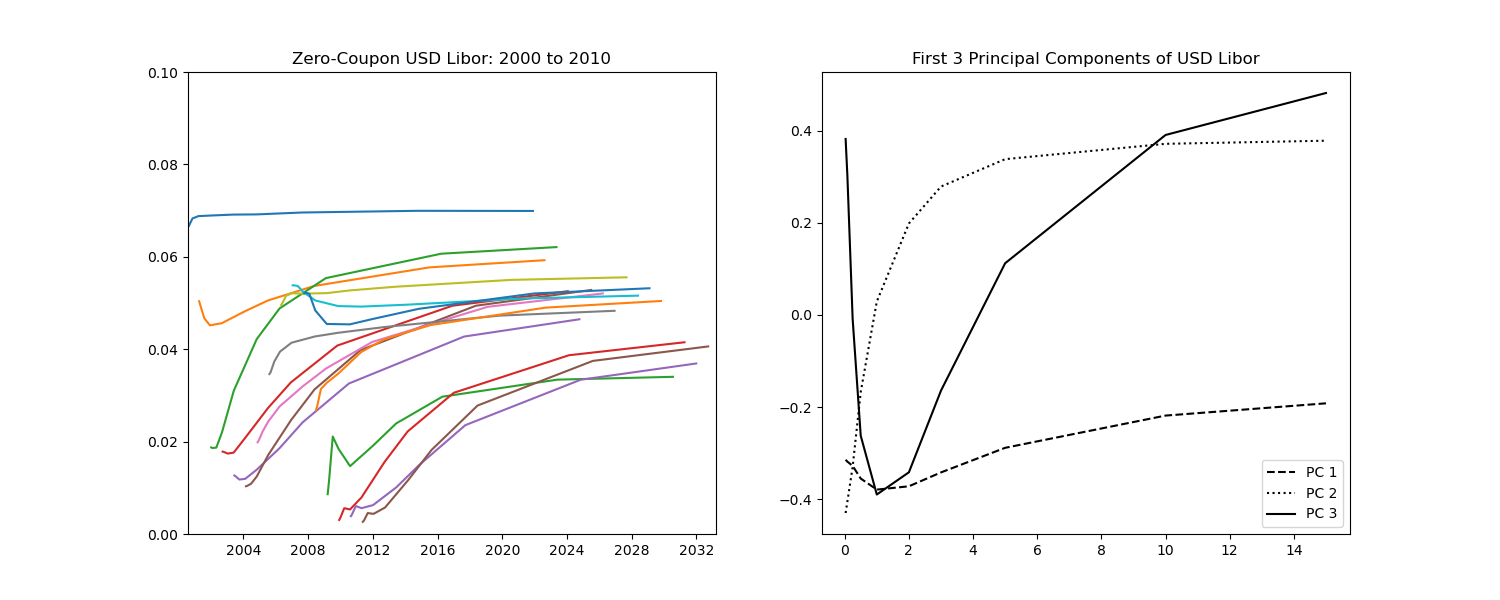

In [26]:
from sklearn import decomposition
pca = decomposition.PCA()
# compute rate change
zc_diff = np.diff(zc_rate, axis=0)
# PCA on rate change
zc_pca = pca.fit(zc_diff)

fig = plt.figure()
fig.set_size_inches(15,6)

ax = fig.add_subplot(121)

# compute x-axis limits
dtMin = dt_maturity[0,0]
dtMax = dt_maturity[-1,-1]
    
ax.set_xlim(dtMin, dtMax)
ax.set_ylim(0.0, 0.1)
    
# plot a few curves
for i in range(0, len(dtI),3):
    ax.plot(dt_maturity[i,], zc_rate[i,])
plt.title('Zero-Coupon USD Libor: 2000 to 2010')

ax2 = fig.add_subplot(122)
ttm = np.array(days)/365.0
ax2.plot(ttm, zc_pca.components_[0], 'k--', ttm, zc_pca.components_[1], 'k:', ttm, zc_pca.components_[2], 'k')
leg = ax2.legend(('PC 1', 'PC 2', 'PC 3'))
plt.title('First 3 Principal Components of USD Libor')
plt.show()
